In [125]:
# Import things
%matplotlib inline
import matplotlib
#matplotlib.use('Agg')

import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as md
import pandas as pd
from matplotlib import rcParams
import sys
from netCDF4 import Dataset, MFDataset,num2date,date2num
sys.path.append('/Users/heather/ICECAPS-ACE/DataParse/')

from utils import *

# Supress warnings for sake of log file
import warnings
warnings.filterwarnings("ignore")


rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'
rcParams.update({'font.size': 14}) 
rcParams['axes.titlepad'] = 14 
rcParams['xtick.major.pad']='10'
rcParams['ytick.major.pad']='10'

flatten = lambda l: [item for sublist in l for item in sublist]

In [126]:
# Netcdf location
dloc = '/Volumes/Data/ICECAPSarchive/ACE_netcdfs/'

# Start and stop date
start = pd.datetime(2019,6,15,0,0)
stop = pd.datetime(2019,8,1,0,0)
day_list = pd.date_range(start,stop,freq='1D')

# Plotting setup
#myFmt = md.DateFormatter('%d/%m')
#rule = md.DayLocator(interval=5)

myFmt = md.DateFormatter('%H')
rule = md.HourLocator(interval=3)


In [128]:
# Get original flux data

def get_flux_estimations(start,stop,d_loc,avp):
    f_date_list = pd.date_range(start.date(),stop.date(),freq='1D')
    flux_out = pd.DataFrame(columns=['SHF', 'LHF', 'MOMFU', 'QC_LHF', 'QC_SHF', 'QC_MOMFU'])
    QC_out = pd.DataFrame(columns=['Dates','skew_u','skew_v','skew_w','skew_T','skew_q','kurt_u','kurt_v','kurt_w','kurt_T','kurt_q','sst_wu','sst_wv','sst_wt','sst_wq','Obukhov','BowenRatio','FrictionU','ZoverL','sigma_w','itc_w','quality_wu','quality_wv','quality_wt','quality_wq'])
    for date in f_date_list: 
        f1 = d_loc + r'Flux_estimates/Flux_estimates_%smin_%s.csv'%(avp,str(date.date()))
        f2 = d_loc + r'Flux_QC/Flux_QC_%smin_%s.csv'%(avp,str(date.date()))                      
        try:
            data = pd.read_csv(f1,parse_dates=[0],index_col=[0])
            qc_dat = pd.read_csv(f2,parse_dates=[0],index_col=[0])
        except:
            print('No data for %s'%str(date.date()))
            continue

        flux_out = flux_out.append(data,sort=True)
        QC_out = QC_out.append(qc_dat,sort=True)

    # Get rid of any duplicates
    flux_out = flux_out[~flux_out.index.duplicated()]
    QC_out = QC_out[~QC_out.index.duplicated()]

    # Crop to datetime
    flux_out=flux_out[start:stop]
    QC_out=QC_out[start:stop]
    
    return flux_out,QC_out
      
def qc_flux(flux,qc_lev):
    qcd = flux.copy()
    qcd['LHF'][flux['QC_LHF']==0]=np.nan
    qcd['SHF'][flux['QC_SHF']==0]=np.nan
    qcd['MOMFU'][flux['QC_MOMFU']==0]=np.nan
    if qc_lev==1: 
        qcd = flux.copy()
        qcd['LHF'][flux['QC_LHF']==2]=np.nan
        qcd['SHF'][flux['QC_SHF']==2]=np.nan
        qcd['MOMFU'][flux['QC_MOMFU']==2]=np.nan      
    
    return qcd

# Flux directory
d_loc = '/Volumes/Data/ICECAPSarchive/fluxtower/processed/TurbulentFluxes/'

# Get flux estimates and qc data
flux_15, QC_15 = get_flux_estimations(start,stop,d_loc,15)
flux_30, QC_30 = get_flux_estimations(start,stop,d_loc,30)

# QC flux data
# level 2 gives you all the 1 and 2 flagged data
# level 1 just gives you the 1 flagged data
flux_15_qcd = qc_flux(flux_15,1)
flux_30_qcd = qc_flux(flux_30,1)

In [129]:
# Get flux netcdfs 

def get_nc(file_list,var_list):
    if len(file_list)>1:
        nc = MFDataset(file_list,'r',aggdim='time')
    elif len(file_list)==1:
        nc = Dataset(file_list[0],'r')
    else:
        print('No data')

    times = num2date(nc.variables['time'][:],nc.variables['time'].units)
    all_vars=[]
    for i in range(0,len(var_list)):  
            all_vars.append(nc.variables[var_list[i]][:])          
    return times, all_vars

def get_flist(base,level,avp,day_list):
    file_list=[]
    for day in day_list: 
        file_list.append(dloc + base + '/' + 'ACE-flux-%s_Summit_%s_%s_%s_v1.nc'%(level,day.strftime('%Y%m%d'),base,avp))
    return file_list




In [130]:
flist = get_flist('flux-estimates',1,'30min',day_list)
var_list = ['momentum_flux_u','upward_sensible_heat_flux_in_air','upward_latent_heat_flux_in_air']
times, [momu, Hs, Hl] = get_nc(flist,var_list)

In [131]:
orig_momu = flux_30_qcd['MOMFU']
orig_SHF = flux_30_qcd['SHF']
orig_LHF = flux_30_qcd['LHF']

In [132]:

def qc_var(flist,subs=''):
    all_vars = Dataset(flist[0],'r').variables.keys()
    qc_vars = [s for s in all_vars if 'qc_flag' in s]
    subset_qcs = [s for s in qc_vars if subs in s]
    w_qcs = [s for s in qc_vars if '_w' in s]


    times, qcs_out = get_nc(flist,subset_qcs)
    times, wqcs_out = get_nc(flist,w_qcs)

    qcs_out = np.asarray(qcs_out)
    wqcs_out = np.asarray(wqcs_out)
    all_qcs = np.append(wqcs_out,qcs_out,axis=0)

    qc_final = np.ones(len(times))
    for i in range(0,len(times)):
        if (all_qcs[:,i] == 2).any():
            qc_final[i]= 2
        if (all_qcs[:,i] == 0).any():
            qc_final[i]= 0  
    
    return qc_final

Hs_qc = qc_var(flist,'_ts')  
Hl_qc = qc_var(flist)
momu_qc = qc_var(flist,'_u')

In [133]:
Hs_masked = np.ma.masked_where(Hs_qc!=1,Hs)
Hl_masked = np.ma.masked_where(Hl_qc!=1,Hl)
momu_masked = np.ma.masked_where(momu_qc!=1,momu)


Text(0, 0.5, 'MOMu, W m$^{-2}$')

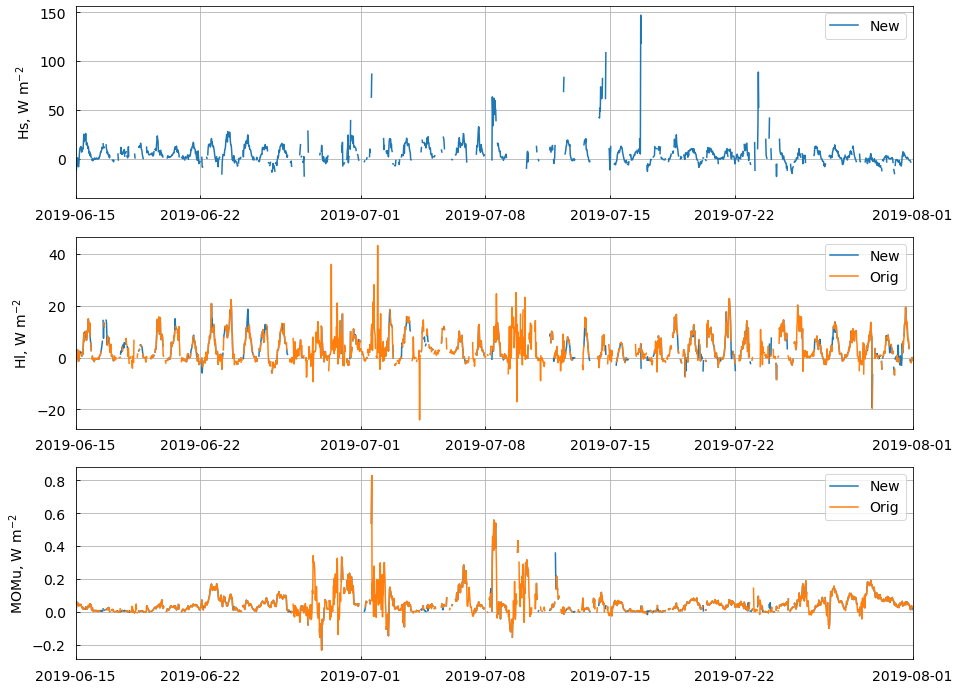

In [135]:
    
fig = plt.figure(figsize=(15,12))
ax1 = fig.add_subplot(311)
ax1.grid(True)
ax1.plot(times,Hs_masked,label='New')
#ax1.plot(orig_SHF,label='Orig')
ax1.legend()
ax1.set_xlim(start,stop)
#ax1.set_ylim(0.5,1.5)
ax1.set_ylabel('Hs, W m$^{-2}$')   

ax2 = fig.add_subplot(312)
ax2.grid(True)
ax2.plot(times,Hl_masked,label='New')
ax2.plot(orig_LHF,label='Orig')
ax2.legend()
ax2.set_xlim(start,stop)
#ax1.set_ylim(0.5,1.5)
ax2.set_ylabel('Hl, W m$^{-2}$') 

ax3 = fig.add_subplot(313)
ax3.grid(True)
ax3.plot(times,momu_masked,label='New')
ax3.plot(-orig_momu,label='Orig')
ax3.legend()
ax3.set_xlim(start,stop)
#ax1.set_ylim(0.5,1.5)
ax3.set_ylabel('MOMu, W m$^{-2}$') 

#ax3.xaxis.set_major_formatter(myFmt)
#ax3.xaxis.set_major_locator(rule)